### Camera Pose Estimation

In this lab you will manually create 3D-2D point correspondences in a picture of an object and compute the pose of the camera (the 3x4 projection matrix) using the "direct linear transform" (DLT).

1. First you need some object, such a laptop, a book, or a table -- anything that has points on it that you can measure.  Using a ruler, a measuring tape, or even just your thumb, measure six points on the object.  (Alternatively, you can find a picture online of some regular object like a cube where you can accurately guess what the measurements would be.)

You need to choose a coordinate system for the object, i.e., choose a point for the origin, and the directions of the X, Y, and Z axes.  For example, on a book, the top-left corner could be the origin, with the front cover being the X-Y plane, and the Z axis going along the spine.

The points can be anywhere on the object, as long as they are not all in a line (collinear).

Store the points in a list or Numpy array.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

image = plt.imread('rubiks-cube.png')

In [27]:
points_3d = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 1]
], dtype=np.float64)

2. Now take a picture of the object where you can see all six points.  Use an image editor or whatever online utility you can find to determine the pixel coordinates of the six points.

Store the 2D point locations in an list or array here, in the same order as the 3D points above.

In [28]:
points_2d = np.array([
    [65, 182],
    [598, 77],
    [476, 322],
    [74, 828],
    [1017, 210],
    [476, 993]
], dtype=np.float64)

Plot the 2d points on top of the image to make sure everything looks good.

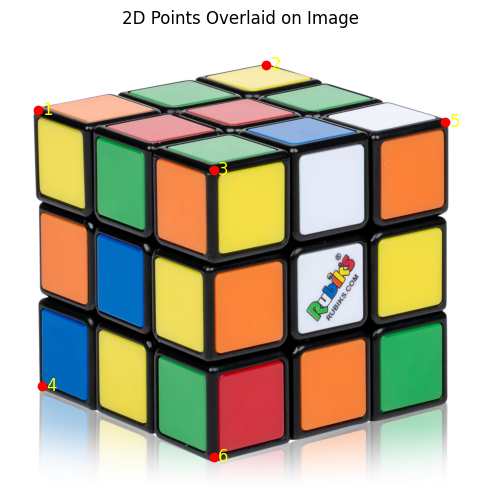

In [29]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.scatter(points_2d[:, 0], points_2d[:, 1], c='r', marker='o')
for i, (x, y) in enumerate(points_2d):
    plt.text(x + 10, y + 10, f'{i+1}', color='yellow', fontsize=12)
plt.title("2D Points Overlaid on Image")
plt.axis('off')
plt.show()

3. Let $\mathbf{X}$ be the 3D point and $\mathbf{x}$ be the corresponding 2D point (in homogeneous coordinates):

$$\mathbf{X}=\begin{bmatrix}X\\Y\\Z\\1\end{bmatrix}, \mathbf{x}=\begin{bmatrix}x\\y\\1\end{bmatrix}$$

(Note: I use bold-face letters like $\mathbf{X}$ to indicate vectors and regular letters like $X$ or $x$ to indicate scalars.  I will write $\mathbf{0}$ to mean a vector of zeros.)

Now you will calculate the $3\times4$ pose matrix relating the 3D points and the 2D points:

$$\mathbf{x} \sim \mathbf{P}\mathbf{X}$$

Recall from lecture that after converting to inhomogeneous coordinates we have:

$$(\mathbf{P}_3\mathbf{X})x-\mathbf{P}_1\mathbf{X}=0$$
$$(\mathbf{P}_3\mathbf{X})y-\mathbf{P}_2\mathbf{X}=0$$

where $\mathbf{P}_1,\mathbf{P}_2$ and $\mathbf{P}_3$ are the three rows of matrix $\mathbf{P}$.

Now we can re-write our equations as a $12\times2$ matrix of coefficients:

$$
\begin{bmatrix}
\mathbf{P_1} &
\mathbf{P_2} &
\mathbf{P_3}
\end{bmatrix}
\begin{bmatrix}
-\mathbf{X} & \mathbf{0} \\
 \mathbf{0} & -\mathbf{X} \\
 x\mathbf{X} & y\mathbf{X}
\end{bmatrix}
=
\begin{bmatrix}0 & 0\end{bmatrix}$$

If you transpose this we get a more traditional form where the equations are on the rows rather than the columns.

$$
\begin{bmatrix}
-\mathbf{X}^T & \mathbf{0} &  x\mathbf{X}^T \\
\mathbf{0} & -\mathbf{X}^T & y\mathbf{X}^T
\end{bmatrix}
\begin{bmatrix}
\mathbf{P_1}^T \\
\mathbf{P_2}^T \\
\mathbf{P_3}^T
\end{bmatrix}
=
\begin{bmatrix}0 \\ 0\end{bmatrix}$$

You can create this $2\times12$ matrix for each 3D-2D correspondence and then concatenate to create a $12\times12$ matrix of coefficients $\mathbf{A}$.  Then solve the system $\mathbf{A}\mathbf{p}=\mathbf{0}$ using the code block below.  Then rearrange $\mathbf{p}$ into the $3\times4$ matrix $\mathbf{P}$.

In [30]:
A = np.zeros((2 * points_3d.shape[0], 12))

for i in range(points_3d.shape[0]):
    X, Y, Z = points_3d[i]
    x, y = points_2d[i]
    X_h = np.array([X, Y, Z, 1.0])
    row_idx = 2 * i
    
    A[row_idx, 0:4]   = -X_h
    A[row_idx, 4:8]   = 0
    A[row_idx, 8:12]  =  x * X_h
    A[row_idx + 1, 0:4]  = 0
    A[row_idx + 1, 4:8]  = -X_h
    A[row_idx + 1, 8:12] =  y * X_h


In [31]:
# code to solve Ap = 0 (find right null vector of A):
U,S,Vh = np.linalg.svd(A)
p = Vh[-1,:].T
P = p.reshape(3, 4)

4. Verify that the pose matrix solution is correct by calculating the residuals $\mathbf{A}\mathbf{p}$.  All of the residuals should be small numbers.

Note that in numpy `@` is the matrix multiplication operator, not `*`.

In [32]:
residuals = A @ p
print("Residuals:", residuals)

Residuals: [ 1.78638525e-04 -5.26986828e-04 -1.16200216e-04  3.70115701e-04
 -1.79133330e-04  5.26607338e-04 -6.27631587e-05  1.56924386e-04
  1.16749636e-04 -3.70216950e-04  6.27734482e-05 -1.56262920e-04]


5. Plot the 2D points and the projected 3D points on the image to visually verify your solution.

To project a 3D point you calculate $\mathbf{P}\mathbf{X}$ and then convert to inhomogeneous (divide by Z).

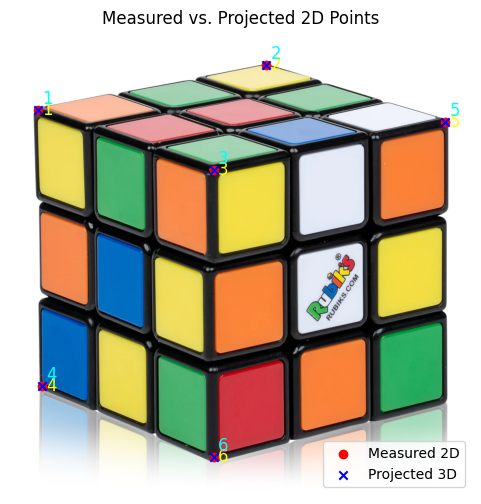

In [33]:
projected_2d = []
for X in points_3d:
    X_h = np.hstack([X, 1.0])            
    x_h = P @ X_h                        
    x_proj = x_h[:2] / x_h[2]            
    projected_2d.append(x_proj)
projected_2d = np.array(projected_2d)    

# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')

# red dots for measured 2D points
plt.scatter(points_2d[:, 0], points_2d[:, 1], c='r', marker='o', label='Measured 2D')

# blue crosses for projected 3d to 2d points
plt.scatter(projected_2d[:, 0], projected_2d[:, 1], c='b', marker='x', label='Projected 3D')
for i, (xm, ym) in enumerate(points_2d):
    plt.text(xm + 10, ym + 10, f'{i+1}', color='yellow', fontsize=12)
for i, (xp, yp) in enumerate(projected_2d):
    plt.text(xp + 10, yp - 15, f'{i+1}', color='cyan', fontsize=12)

plt.title("Measured vs. Projected 2D Points")
plt.legend(loc='lower right')
plt.show()

6. (Optional): Calculate the re-projection error of each point.

The re-projection error is the Euclidean distance between the true 2D point and the corresponding projected 3D point.  You can compute the Euclidean distance using `np.linalg.norm(point-proj)` where `point` is the true point and `proj` is the projected 3D point.